In [151]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


In [152]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (1901023, 21)


In [153]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"

USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"

LATE_FLAG_COL = "Verspätet"

borrowings[USER_ID_COL] = pd.to_numeric(borrowings[USER_ID_COL], errors="coerce").astype("Int64")

borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")



## User-level aggregation

In this step, the borrowing data is aggregated at the **user level**.
Only entries with a valid user identifier are considered.

For each user, we compute:
- the total number of borrowings,
- the proportion and count of late returns,
- average and maximum loan duration,
- average and maximum number of extensions,
- the associated user category.

This aggregated table serves as the basis for subsequent analyses of user behavior and performance.


In [154]:
# --- aggregate user-level statistics ---
borrowings_user = borrowings[borrowings[USER_ID_COL].notna()].copy()

borrowings_user = (
    borrowings_user
    .groupby(USER_ID_COL)
    .agg(
        n_borrowings=("issue_id", "count"),
        late_rate=("late_bool", "mean"),
        n_late=("late_bool", "sum"),
        avg_duration=("Leihdauer", "mean"),
        max_duration=("Leihdauer", "max"),
        avg_extensions=("Anzahl_Verlängerungen", "mean"),
        max_extensions=("Anzahl_Verlängerungen", "max"),
        user_category=(USER_CATEGORY_COL, "first"),
    )
    .reset_index()
)

borrowings_user.head()


,Benutzer-Systemnummer,n_borrowings,late_rate,n_late,avg_duration,max_duration,avg_extensions,max_extensions,user_category
0,46,3,0.3333,1,39.6667,61.0000,0.3333,1,INS
1,50,980,0.0020,2,32.5643,313.0000,0.8194,7,MPA
2,51,22,0.0000,0,16.6364,83.0000,0.1818,2,MPA
3,53,5,0.0000,0,48.4000,72.0000,1.8000,3,MPA
4,54,958,0.0209,20,58.0470,330.0000,2.1127,6,MPA


In [155]:
borrowings_user["n_borrowings"].describe()

count   20,800.0000
mean        86.0012
std        170.8637
min          1.0000
25%          7.0000
50%         25.0000
75%         91.0000
max      5,164.0000
Name: n_borrowings, dtype: float64

### Defining the analysis population (EDA)

The distribution of borrowings per user is highly right-skewed, with a small number of users exhibiting extremely large borrowing counts.
As shown by the summary statistics, the median user borrows 27 items, while only a very small fraction exceeds several hundred borrowings.

To prevent these extreme cases from dominating averages and visualizations, the analysis is restricted to users with between 1 and 500 borrowings.
This threshold retains the vast majority of users while ensuring that observed patterns reflect typical borrowing behavior.


In [156]:
#-- filter user-level table for special cases ---


borrowings_user = borrowings_user[
    (borrowings_user["n_borrowings"] >= 1) &
    (borrowings_user["n_borrowings"] <= 500)
].copy()

borrowings_user["n_borrowings"].describe()

count   20,223.0000
mean        65.0888
std         94.5233
min          1.0000
25%          6.0000
50%         24.0000
75%         81.0000
max        500.0000
Name: n_borrowings, dtype: float64

## Late returns and borrowing intensity

This analysis explores how late return behavior relates to borrowing intensity at the user level.
By examining both raw user-level data and aggregated borrowing bins, we assess whether users with more borrowing experience tend to manage loan deadlines differently from infrequent borrowers.

/tmp/ipykernel_67653/248917829.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


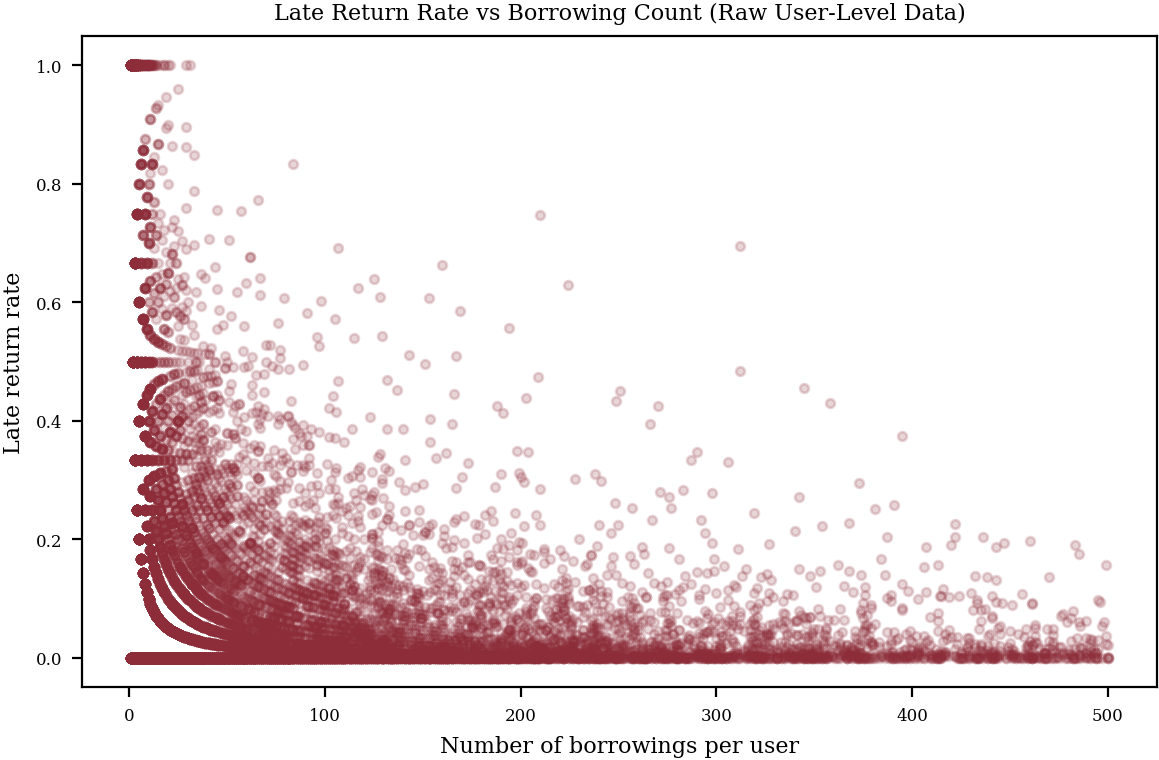

In [157]:
# --- analyze late return rate by borrowing intensity ---

plt.figure(figsize=(6, 4))
plt.scatter(
    borrowings_user["n_borrowings"],
    borrowings_user["late_rate"],
    alpha=0.2,
    s=10
)
plt.xlabel("Number of borrowings per user")
plt.ylabel("Late return rate")
plt.title("Late Return Rate vs Borrowing Count (Raw User-Level Data)")
plt.tight_layout()
plt.show()


As expected, the raw user-level relationship between borrowing frequency and late return rates is highly noisy for users with few borrowings, reflecting small-sample variability. The variance decreases substantially with increasing borrowing count, motivating aggregation into borrowing-frequency bins to reveal systematic trends.


/tmp/ipykernel_67653/1674866852.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("borrowing_bin")


,mean_late_rate,n_users
borrowing_bin,,
1–5,0.1167,3321
6–10,0.0993,2297
11–20,0.0909,2655
21–50,0.0783,3739
51–100,0.0604,2778
101–200,0.0495,2305
201–500,0.0357,1908


/tmp/ipykernel_67653/1674866852.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


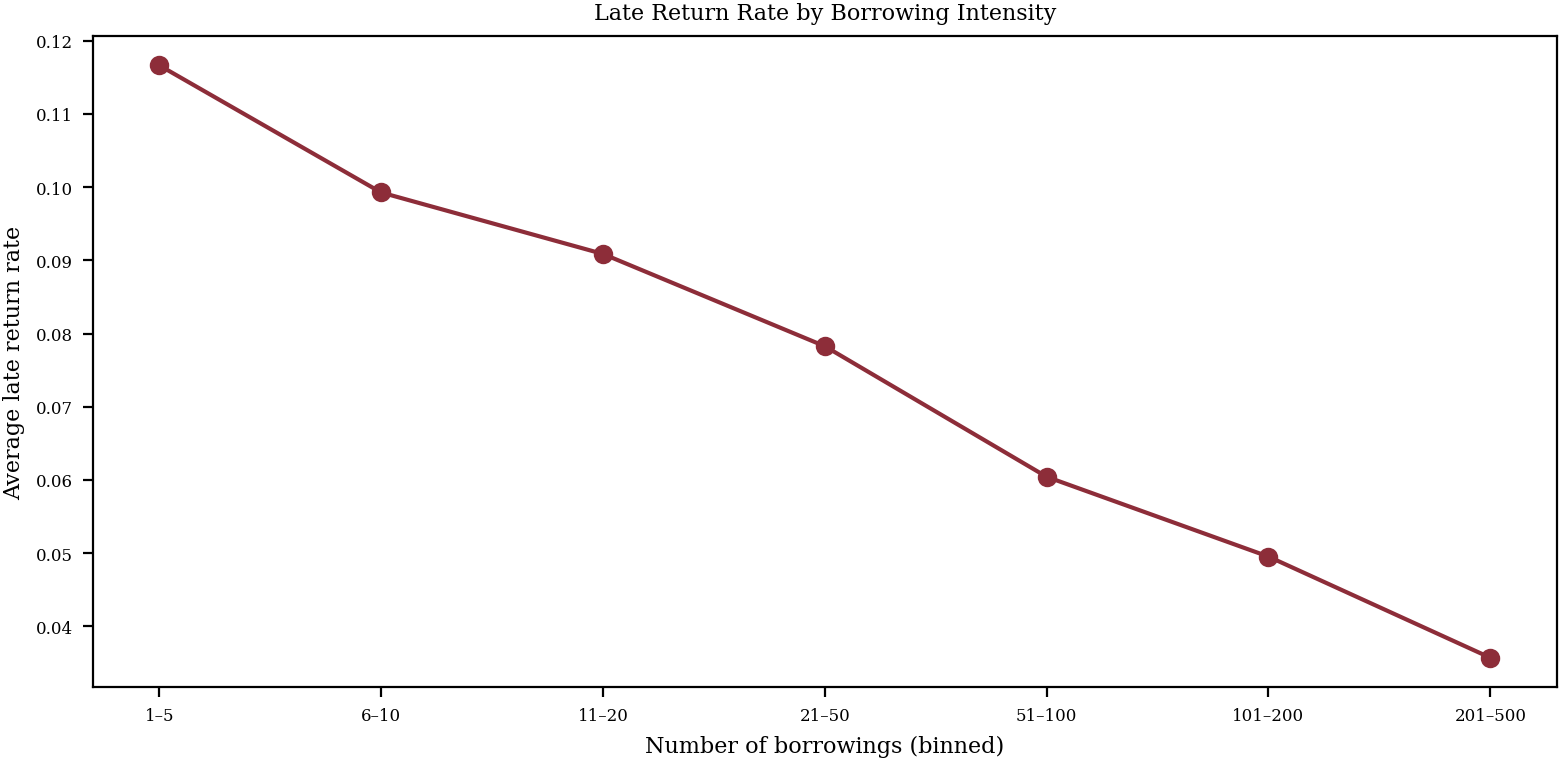

In [158]:
# --- analyze late return rate by borrowing intensity ---

# work on the filtered user-level table
df_borrowing_intensity = borrowings_user.copy()

# define borrowing-intensity bins
bins = [1, 5, 10, 20, 50, 100, 200, 500]
labels = ["1–5", "6–10", "11–20", "21–50", "51–100", "101–200", "201–500"]

df_borrowing_intensity["borrowing_bin"] = pd.cut(
    df_borrowing_intensity["n_borrowings"],
    bins=bins,
    labels=labels,
    right=True
)

# aggregate late rate per bin
bin_summary = (
    df_borrowing_intensity
    .groupby("borrowing_bin")
    .agg(
        mean_late_rate=("late_rate", "mean"),
        n_users=("late_rate", "count")
    )
)

display(bin_summary)

# plot
plt.figure(figsize=(8, 4))
plt.plot(
    bin_summary.index.astype(str),
    bin_summary["mean_late_rate"],
    marker="o"
)
plt.xlabel("Number of borrowings (binned)")
plt.ylabel("Average late return rate")
plt.title("Late Return Rate by Borrowing Intensity")
plt.tight_layout()
plt.show()


The plot shows a clear and monotonic decrease in late return rates with increasing borrowing intensity. Users with few borrowings exhibit the highest late rates, while frequent borrowers are substantially less likely to return items late. This pattern is consistent with a learning or experience effect: as users borrow more often, they appear to manage loan deadlines more reliably. The smooth trend across bins suggests that this relationship reflects systematic behavioral differences rather than random noise.

## Learning over Time within Users

Previous analyses show that frequent borrowers have substantially lower late return rates than occasional users. However, this cross-sectional pattern does not reveal whether this difference reflects learning over time or pre-existing differences between users.

To address this, we examine how late return behavior evolves *within individual users* across their borrowing history. Importantly, experience is defined at the level of **borrowing sessions** rather than individual items, so that multiple items borrowed at the same time are treated as a single experience step. This avoids artificially inflating experience when several items are borrowed in one visit, while still allowing late returns to be measured at the item level.

This approach enables a more meaningful assessment of whether borrowing reliability improves with accumulated experience.


In [159]:
# --- analyze learning effect over time ---

df_user_sessions = borrowings.copy()

# define a borrowing "session" as same user + same issue timestamp
df_user_sessions["issue_session"] = df_user_sessions[ISSUE_COL].dt.floor("D")  # change to ISSUE_COL

# ngroup is global; convert to per-user consecutive numbering
df_user_sessions["session_index"] = (
    df_user_sessions
    .groupby(USER_ID_COL)["issue_session"]
    .transform(lambda s: pd.factorize(s, sort=True)[0] + 1)
)


In [160]:
EXPERIENCE_CUTOFF = 3

df_learning = df_user_sessions.copy()

df_learning["experience_stage"] = np.where(
    df_learning["session_index"] <= EXPERIENCE_CUTOFF,
    "early",
    "experienced"
)

df_learning["experience_stage"].value_counts()


experience_stage
experienced    1690371
early           210652
Name: count, dtype: int64

In [161]:
stage_late_rate = (
    df_learning
    .groupby("experience_stage")["late_bool"]
    .mean()
)

stage_late_rate

experience_stage
early         0.0650
experienced   0.0395
Name: late_bool, dtype: Float64

/tmp/ipykernel_67653/4230281300.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


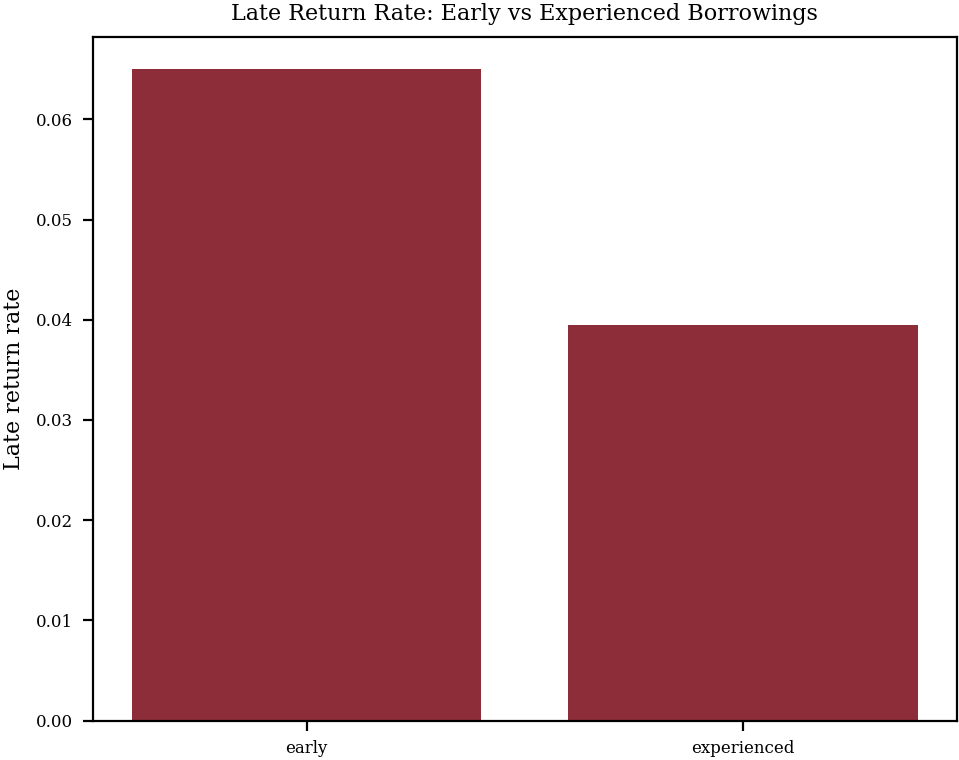

In [162]:
# -- plot late rate by experience stage ---

plt.figure(figsize=(5, 4))
plt.bar(stage_late_rate.index, stage_late_rate.values)
plt.ylabel("Late return rate")
plt.title("Late Return Rate: Early vs Experienced Borrowings")
plt.tight_layout()
plt.show()

The late return rate is substantially higher for early borrowings than for later borrowings of the same users. This decline provides strong evidence of a learning or adaptation effect, whereby users become more reliable as they gain borrowing experience.


## Learning curves

In [163]:
df_curve = df_learning.copy()

# --- compute learning curve ---
learning_curve = (
    df_curve
    .groupby("session_index")["late_bool"]
    .agg(
        late_rate="mean",
        n_obs="count"
    )
    .reset_index()
)

learning_curve.head()

# --- restrict to session indices with sufficient observations ---
MIN_OBS = 3000

max_session = (
    learning_curve
    .loc[learning_curve["n_obs"] >= MIN_OBS, "session_index"]
    .max()
)

print("Max session index with sufficient observations:", max_session)

learning_curve = learning_curve.loc[
    learning_curve["session_index"] <= max_session
].copy()

learning_curve.head()



Max session index with sufficient observations: 93.0


,session_index,late_rate,n_obs
0,1.0000,0.0681,80226
1,2.0000,0.0630,68161
2,3.0000,0.0632,62265
3,4.0000,0.0599,57737
4,5.0000,0.0580,54069


/tmp/ipykernel_67653/4011158571.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


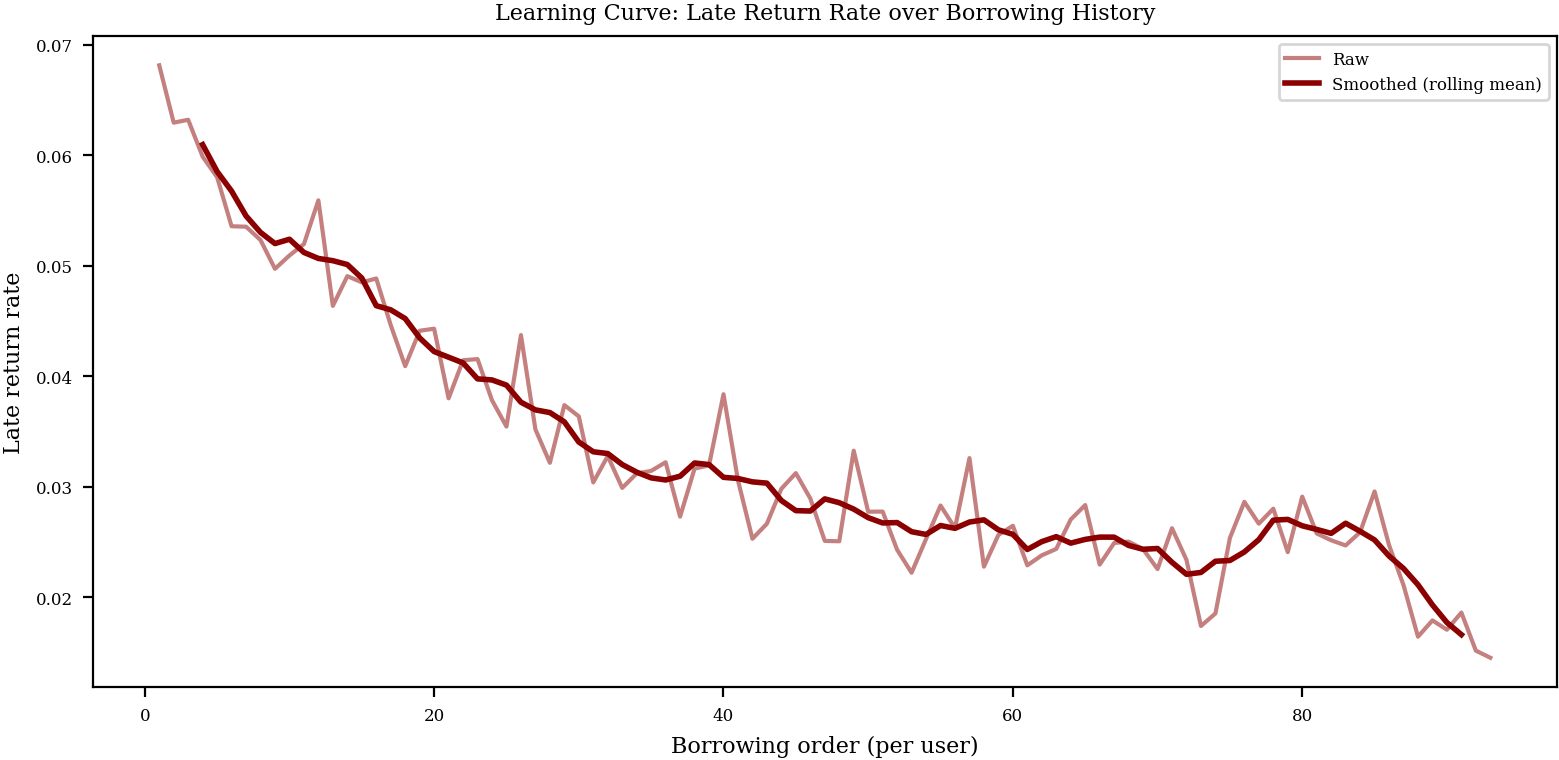

In [164]:
# -- plot learning curve ---

learning_curve["late_rate_smooth"] = (
    learning_curve["late_rate"]
    .rolling(window=6, center=True)
    .mean()
)

plt.figure(figsize=(8, 4))
plt.plot(
    learning_curve["session_index"],
    learning_curve["late_rate"],
    alpha=0.5,
    color="darkred",
    label="Raw"
)
plt.plot(
    learning_curve["session_index"],
    learning_curve["late_rate_smooth"],
    linewidth=2,
    color="darkred",
    label="Smoothed (rolling mean)"
)
plt.xlabel("Borrowing order (per user)")
plt.ylabel("Late return rate")
plt.title("Learning Curve: Late Return Rate over Borrowing History")
plt.legend()
plt.tight_layout()
plt.show()

In [165]:
z = 1.96  # 95% CI

learning_curve["ci_lower"] = (
    learning_curve["late_rate"]
    - z * np.sqrt(
        learning_curve["late_rate"] * (1 - learning_curve["late_rate"])
        / learning_curve["n_obs"]
    )
)

learning_curve["ci_upper"] = (
    learning_curve["late_rate"]
    + z * np.sqrt(
        learning_curve["late_rate"] * (1 - learning_curve["late_rate"])
        / learning_curve["n_obs"]
    )
)



learning_curve["ci_lower"] = learning_curve["ci_lower"].clip(0, 1)
learning_curve["ci_upper"] = learning_curve["ci_upper"].clip(0, 1)


/tmp/ipykernel_67653/3332203295.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


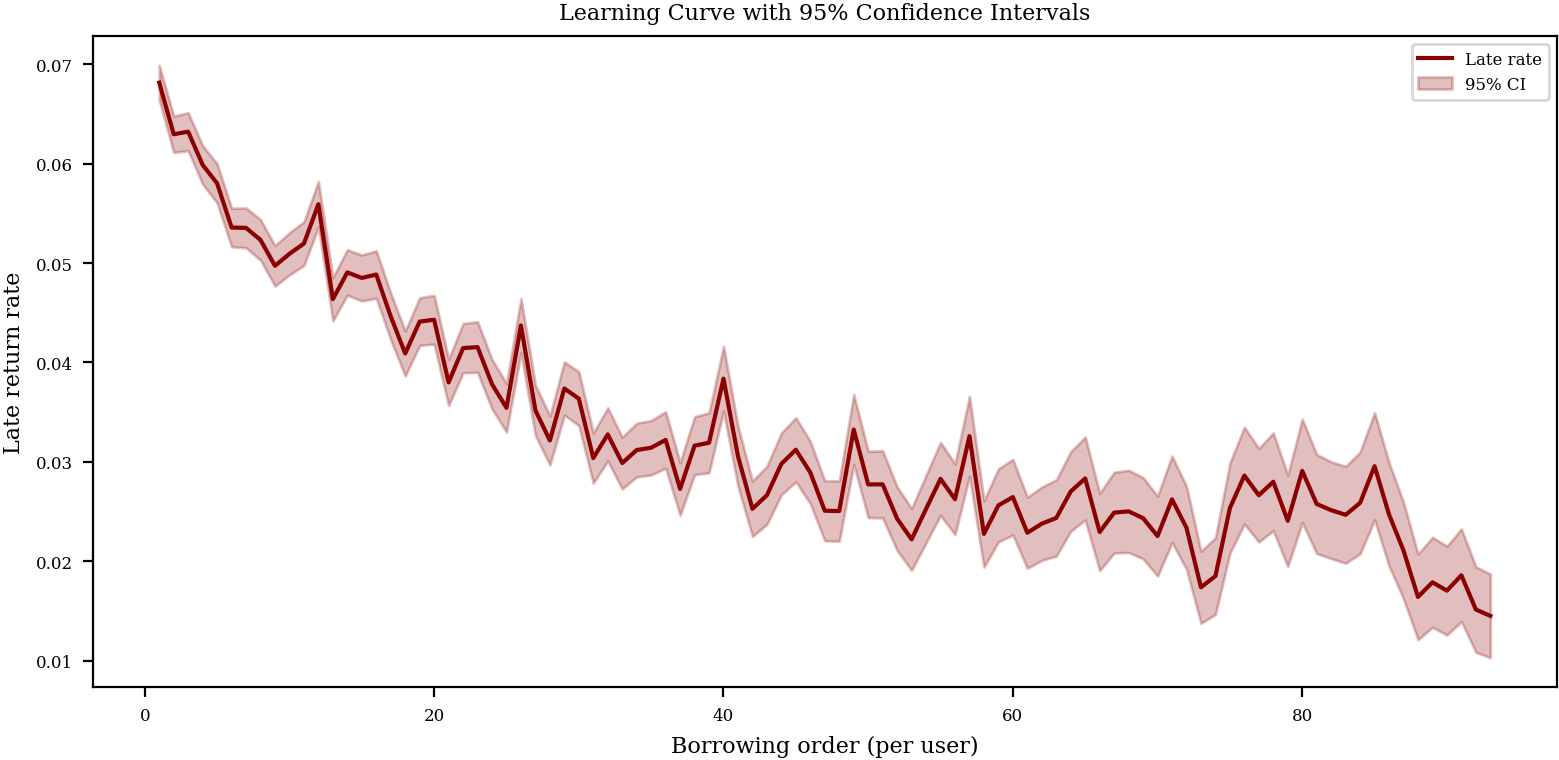

In [166]:
plt.figure(figsize=(8, 4))

plt.plot(
    learning_curve["session_index"],
    learning_curve["late_rate"],
    label="Late rate",
    color="darkred"
)

plt.fill_between(
    learning_curve["session_index"],
    learning_curve["ci_lower"],
    learning_curve["ci_upper"],
    alpha=0.25,
    label="95% CI",
    color="darkred"
)

plt.xlabel("Borrowing order (per user)")
plt.ylabel("Late return rate")
plt.title("Learning Curve with 95% Confidence Intervals")
plt.legend()
plt.tight_layout()
plt.show()


## Does learning differ in Categories
first we define a function that allows us to filter for different categories

In [167]:
def plot_learning_curves_with_categories(
        input_data,
        target_column,
        category_filter,
        show_raw=True,
        min_observations=3000,
        smooth_window=6,
        cutoff=None  # if None use common max
):
    # filter categories (whitelist)
    filtered_data = input_data[input_data[target_column].isin(category_filter)].copy()

    # aggregate per (category, session_index)
    aggregated_data = (
        filtered_data
        .groupby([target_column, "session_index"])["late_bool"]
        .agg(late_rate="mean", n_obs="count")
        .reset_index()
        .sort_values([target_column, "session_index"])
    )

    # per-category max session index that still has enough obs
    max_sessions = (
        aggregated_data[aggregated_data["n_obs"] >= min_observations]
        .groupby(target_column)["session_index"]
        .max()
    )

    # drop categories that never reach min_observations at any session_index
    missing = [c for c in category_filter if c not in max_sessions.index]
    if missing:
        print(f"Dropping categories that don't reach min_observations={min_observations}: {missing}")
        category_filter = [c for c in category_filter if c in max_sessions.index]

    # IMPORTANT: recompute max_sessions based on the kept categories only
    max_sessions = max_sessions.loc[category_filter]

    # cutoff logic
    cutoff_to_use = int(max_sessions.min()) if cutoff is None else int(cutoff)

    # restrict to cutoff
    aggregated_data = aggregated_data[aggregated_data["session_index"] <= cutoff_to_use].copy()

    # enforce "n≥min_observations per point"
    aggregated_data = aggregated_data[aggregated_data["n_obs"] >= min_observations].copy()

    # smooth within each category (min_periods=1 so edges aren't NaN)
    aggregated_data["late_rate_smooth"] = (
        aggregated_data
        .groupby(target_column)["late_rate"]
        .transform(lambda s: s.rolling(window=smooth_window, center=True, min_periods=1).mean())
    )

    # plot
    cycle_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", []) or ["C0","C1","C2","C3","C4"]

    plt.figure(figsize=(9, 4))

    for i, cat in enumerate(category_filter):
        d = aggregated_data[aggregated_data[target_column] == cat]
        if d.empty:
            continue

        color = cycle_colors[i % len(cycle_colors)]

        if show_raw:
            plt.plot(d["session_index"], d["late_rate"],
                     color=color, alpha=0.25, linestyle="--", label=f"{cat} (raw)")
        plt.plot(d["session_index"], d["late_rate_smooth"],
                 color=color, linewidth=2, linestyle="-", label=f"{cat} (smoothed)")

    plt.xlabel("Borrowing session order (per user)")
    plt.ylabel("Late return rate")
    plt.title(f"Learning Curves by {target_column} (up to session {cutoff_to_use}, n≥{min_observations} per point)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Does learning differ in User Categories

/tmp/ipykernel_67653/808223440.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


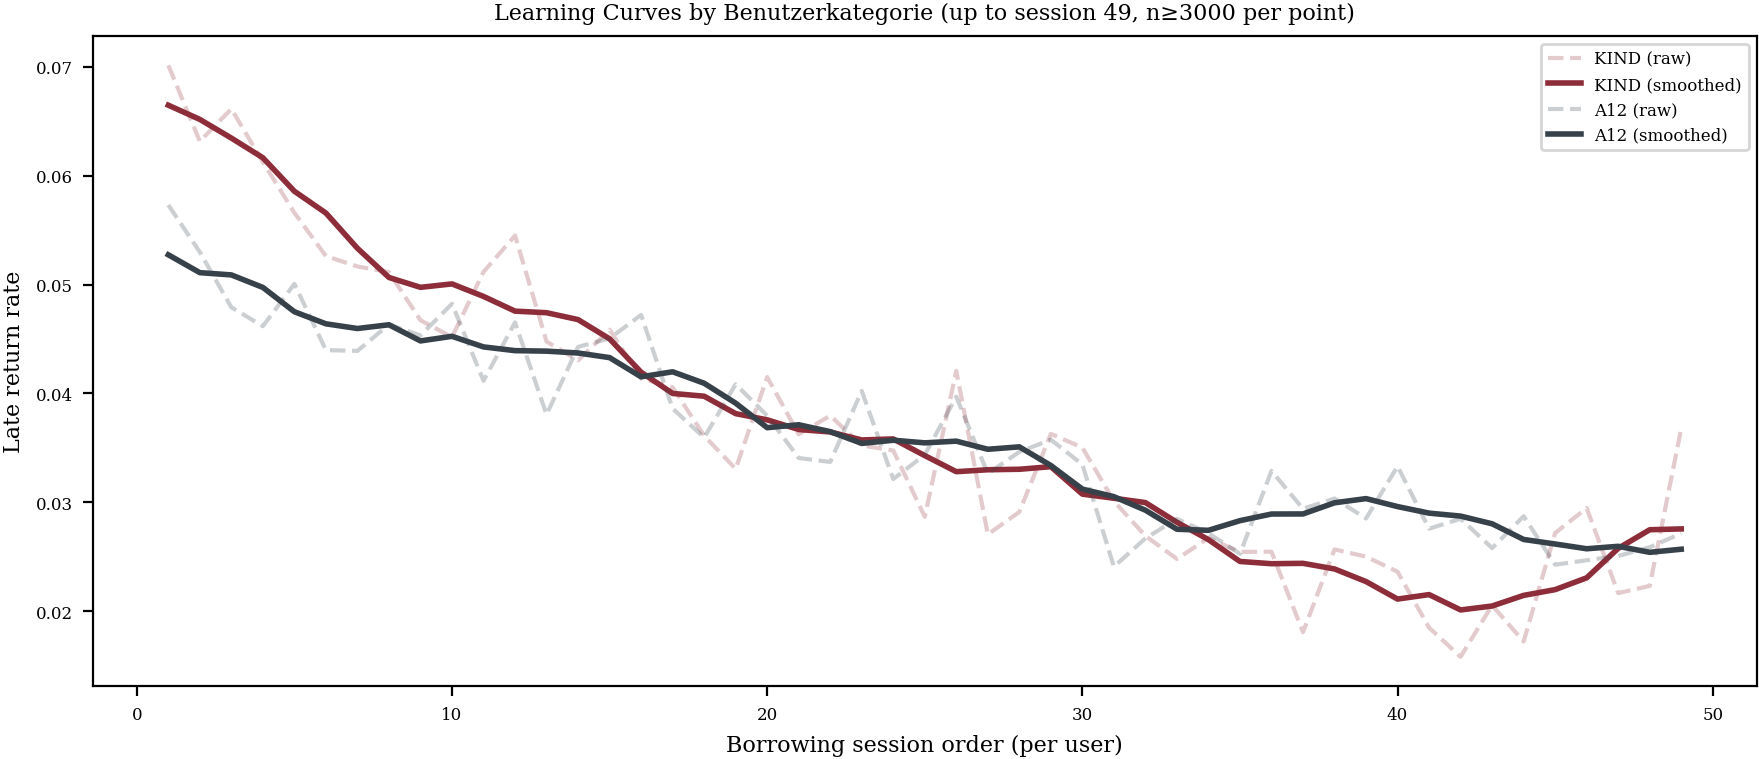

In [168]:
plot_learning_curves_with_categories(df_learning, USER_CATEGORY_COL, ["KIND", "A12"])

## Does learning differ in Media Types

/tmp/ipykernel_67653/808223440.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


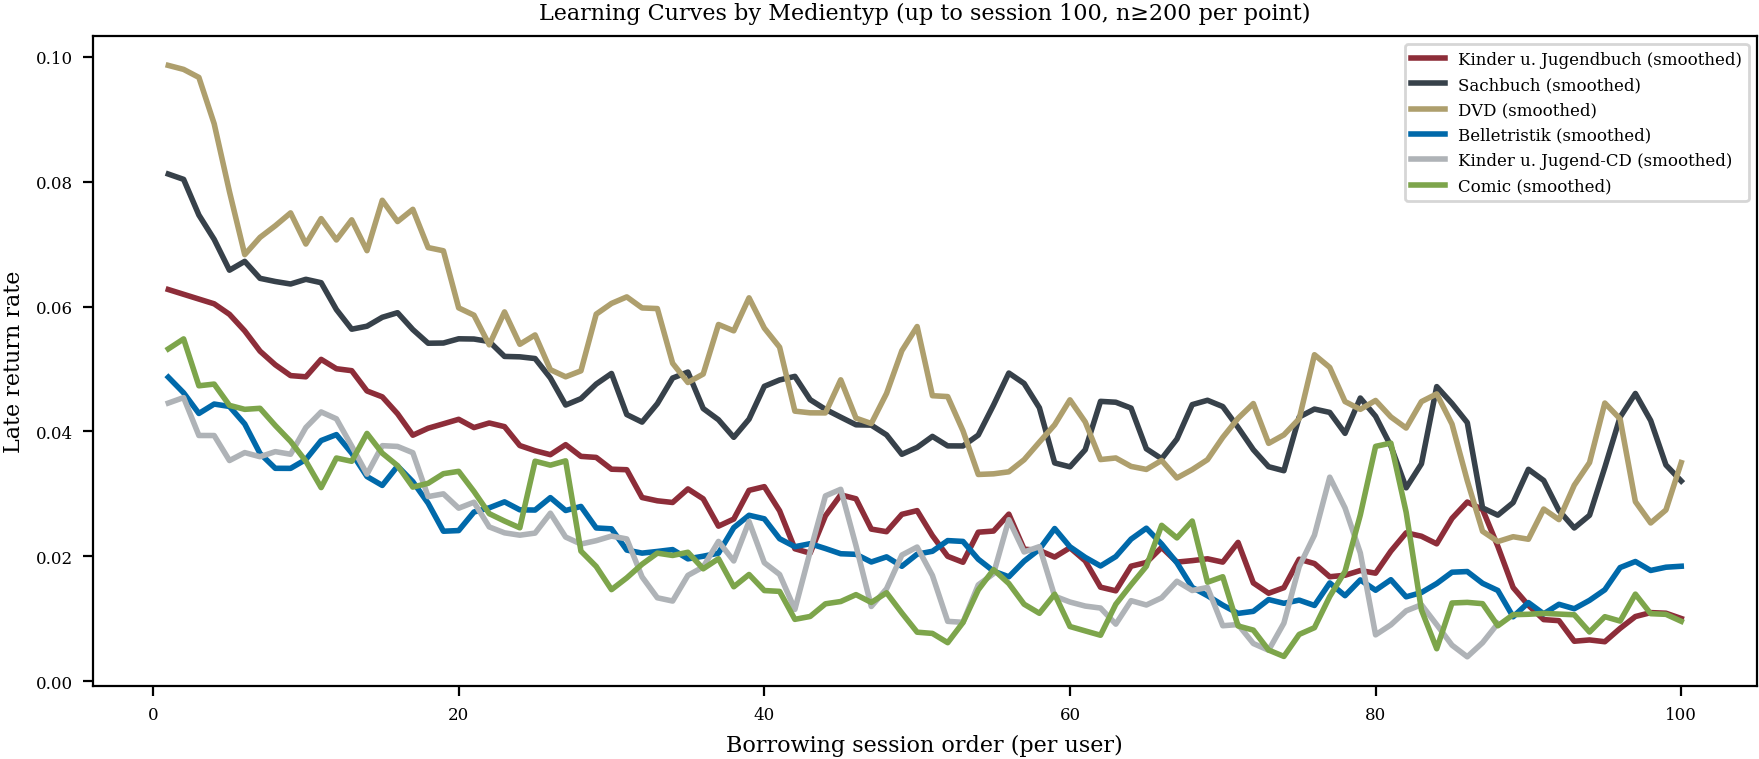

In [169]:
MEDIA_TYPE_COL = "Medientyp"
media_counts = df_learning[MEDIA_TYPE_COL].value_counts(dropna=False)
media_type_whitelist = media_counts[media_counts > 100000].index.tolist()

interesting_types = ["Kinder u. Jugendbuch", "Spiele", "Hörbuch", "Musik-CD",  "Zeitschriften"]

plot_learning_curves_with_categories(df_learning, MEDIA_TYPE_COL, media_type_whitelist, False, 200, 3, 100)

/tmp/ipykernel_67653/808223440.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


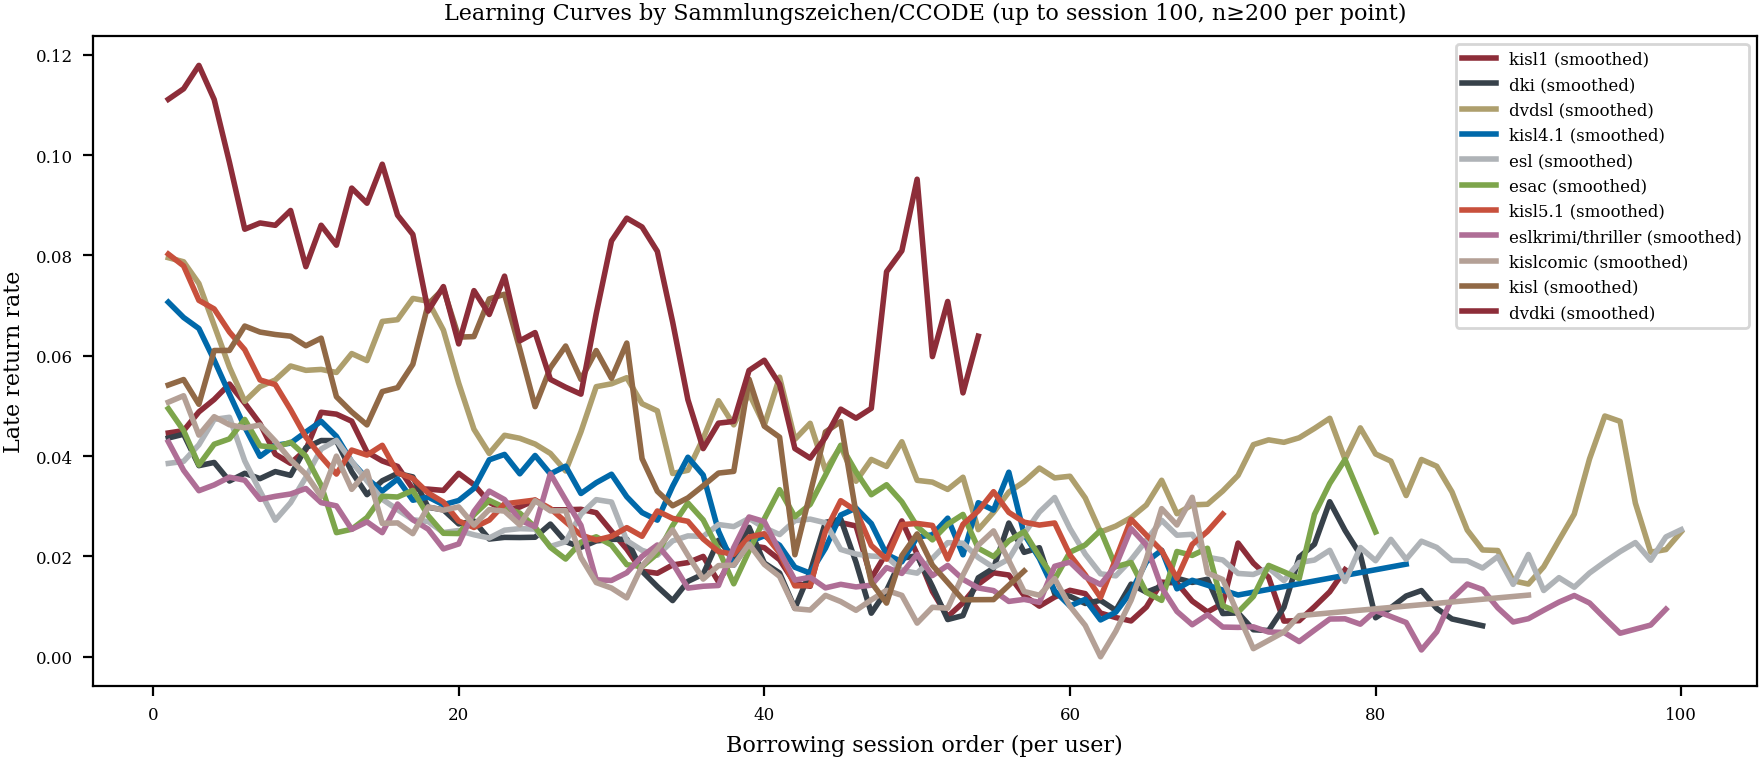

In [170]:
CC_CODE_COL = "Sammlungszeichen/CCODE"
cc_code_counts = df_learning[CC_CODE_COL].value_counts(dropna=False)
cc_code_whitelist = cc_code_counts[cc_code_counts > 50000].index.tolist()

plot_learning_curves_with_categories(df_learning, CC_CODE_COL, cc_code_whitelist, False, 200, 3, 100)

## Number of loans per session and late return

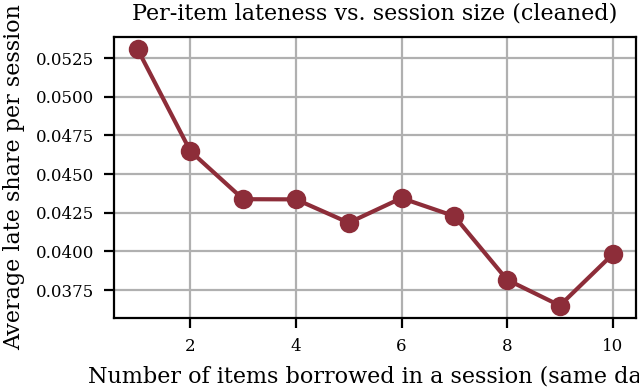

,n_items,mean_late_share,n_sessions
0,1,0.0531,114114
1,2,0.0465,75138
2,3,0.0434,55855
3,4,0.0434,41666
4,5,0.0419,30977
5,6,0.0435,22738
6,7,0.0423,17203
7,8,0.0382,13419
8,9,0.0365,9968
9,10,0.0398,7995


In [171]:
# --- analyze per-item lateness vs. session size ---
df_session_clean = (
    df_user_sessions
    .groupby([USER_ID_COL, "issue_session"])
    .agg(
        n_items=("late_bool", "size"),
        n_late=("late_bool", "sum")   # True counts as 1
    )
    .reset_index()
)

# drop sessions with unknown lateness
df_session_clean = df_session_clean.dropna(subset=["n_late"])

df_session_clean["late_share"] = (
    df_session_clean["n_late"] / df_session_clean["n_items"]
)

# limit large sessions to reduce noise
df_session_clean = df_session_clean[df_session_clean["n_items"] <= 10]

# Average late share by session size
df_late_share_by_size = (
    df_session_clean
    .groupby("n_items")
    .agg(
        mean_late_share=("late_share", "mean"),
        n_sessions=("late_share", "size")
    )
    .reset_index()
)

# Plot
plt.figure()
plt.plot(
    df_late_share_by_size["n_items"],
    df_late_share_by_size["mean_late_share"],
    marker="o"
)
plt.xlabel("Number of items borrowed in a session (same day)")
plt.ylabel("Average late share per session")
plt.title("Per-item lateness vs. session size (cleaned)")
plt.grid(True)
plt.show()

df_late_share_by_size

## Extension Behavior Analysis
Do users with more loan sessions extend more often. Do they learn to extend

/tmp/ipykernel_67653/3849702301.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


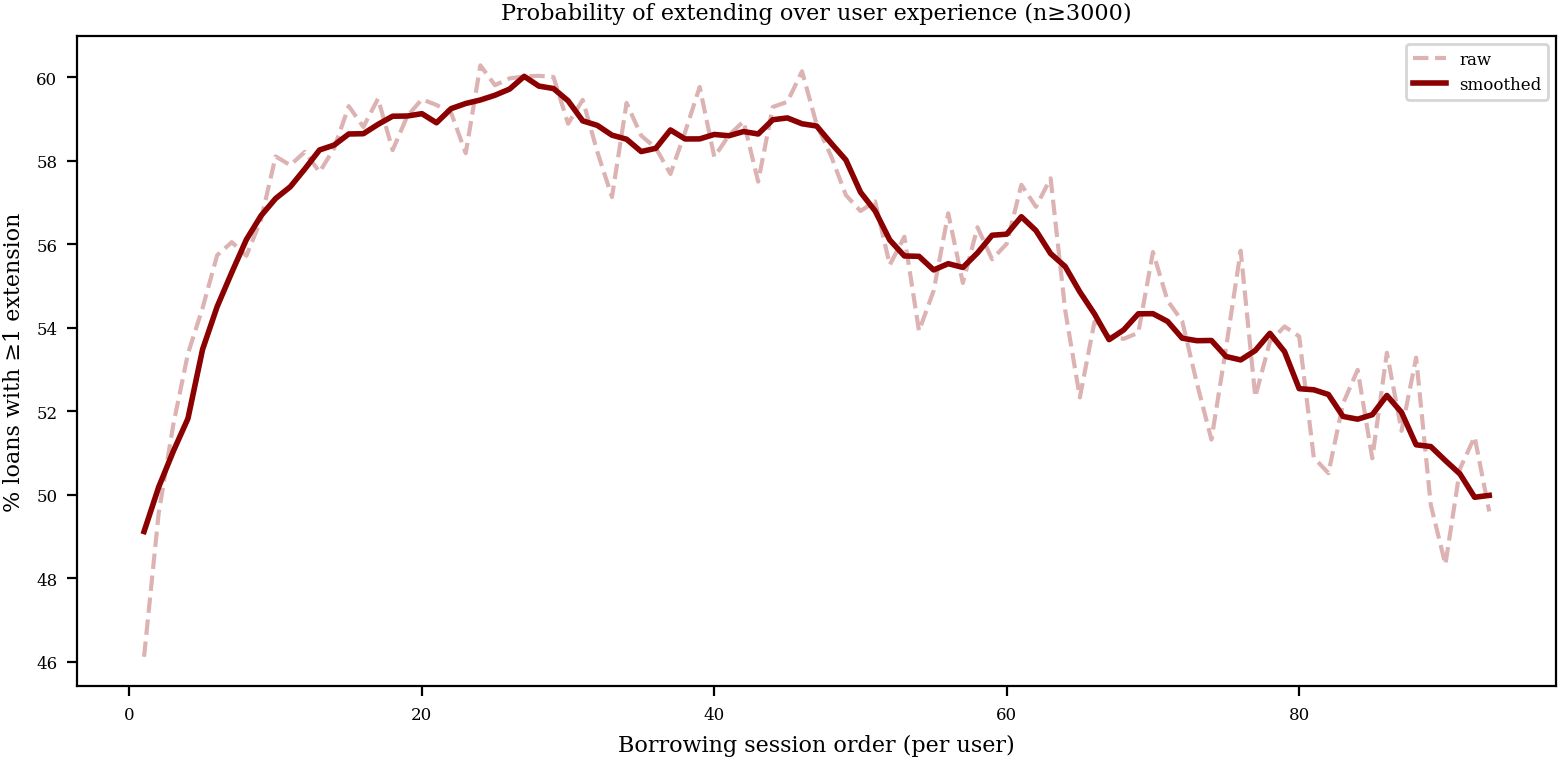

In [172]:
EXTENSION_COL = "Anzahl_Verlängerungen"   # ggf. anpassen
MIN_OBS = 3000
SMOOTH_WINDOW = 6

extension_data_frame = df_learning.copy()
extension_data_frame["ext"] = pd.to_numeric(extension_data_frame[EXTENSION_COL], errors="coerce").fillna(0)

extension_data_frame["extended"] = (extension_data_frame["ext"] >= 1).astype(int)

curve_prob = (
    extension_data_frame
    .groupby("session_index")["extended"]
    .agg(percentage_extended="mean", n_obs="count")
    .reset_index()
    .sort_values("session_index")
)

curve_prob = curve_prob[curve_prob["n_obs"] >= MIN_OBS].copy()
curve_prob["percentage_extended_smooth"] = (
    curve_prob["percentage_extended"]
    .rolling(window=SMOOTH_WINDOW, center=True, min_periods=1)
    .mean()
)

plt.figure(figsize=(8,4))
plt.plot(curve_prob["session_index"], 100*curve_prob["percentage_extended"], color="darkred", alpha=0.3, linestyle="--", label="raw")
plt.plot(curve_prob["session_index"], 100*curve_prob["percentage_extended_smooth"], color="darkred", linewidth=2, label="smoothed")
plt.xlabel("Borrowing session order (per user)")
plt.ylabel("% loans with ≥1 extension")
plt.title(f"Probability of extending over user experience (n≥{MIN_OBS})")
plt.legend()
plt.tight_layout()
plt.show()


There seems to be an interesting increase in the extension rate during the early borrowing sessions. From the first to the 25th session, the share of loans with at least one extension rises by about 10 percentage points. Note that the overall extension rate is still quite low.

But does the exact number of extensions matter. We look at some interesting thresholds.

/tmp/ipykernel_67653/602427681.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


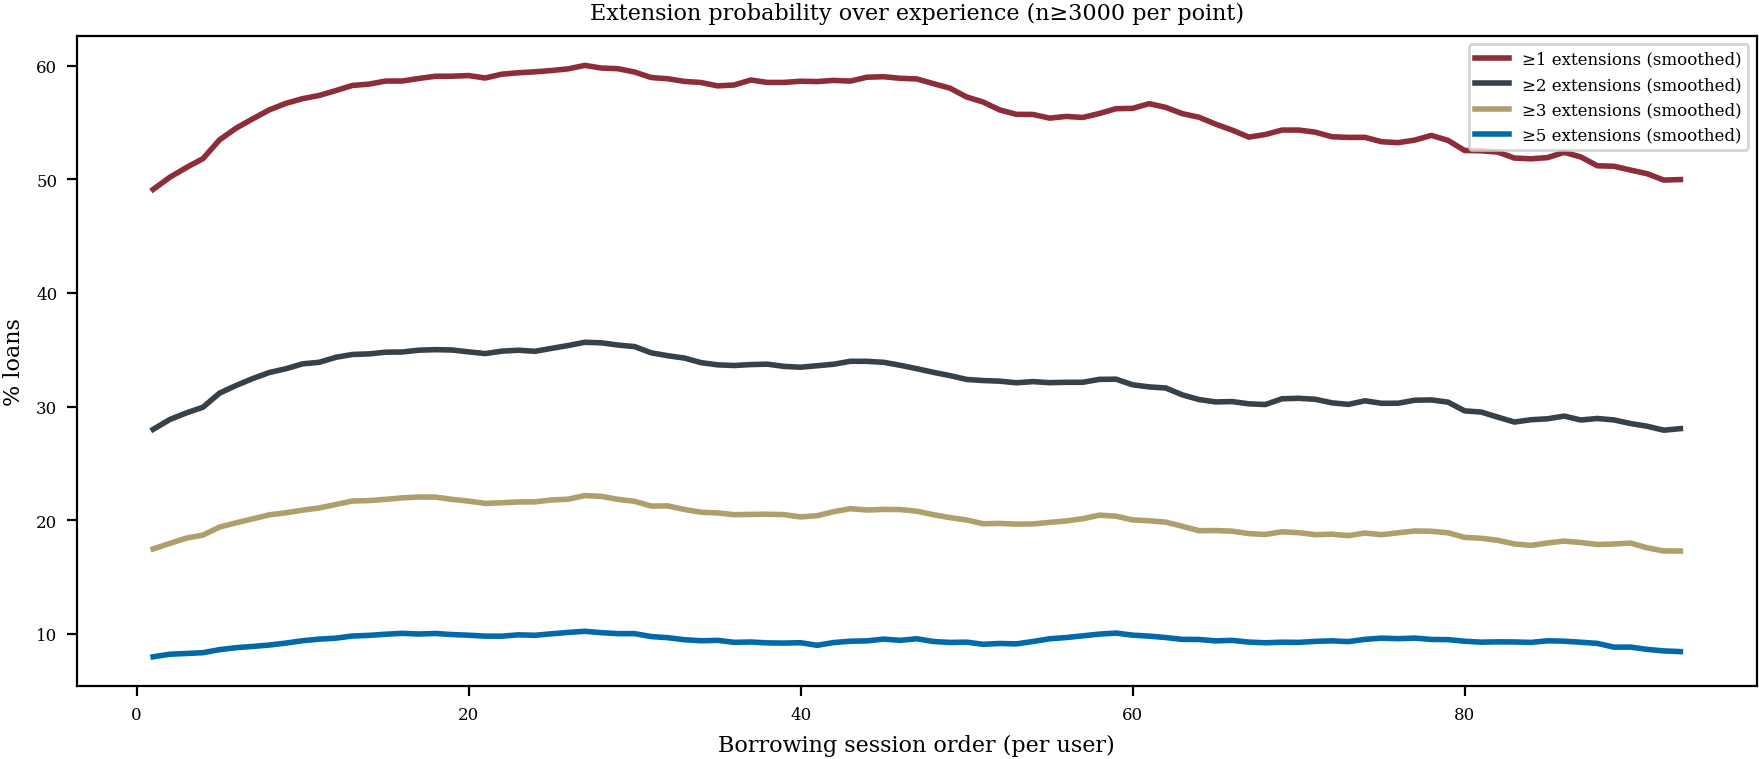

In [173]:
THRESHOLDS = [1, 2, 3, 5]

extension_data_frame = df_learning.copy()
extension_data_frame["ext"] = pd.to_numeric(extension_data_frame[EXTENSION_COL], errors="coerce").fillna(0)

out = []
for k in THRESHOLDS:
    tmp = (
        extension_data_frame.assign(flag=(extension_data_frame["ext"] >= k).astype(int))
        .groupby("session_index")["flag"]
        .agg(rate="mean", n_obs="count")
        .reset_index()
        .sort_values("session_index")
    )
    tmp = tmp[tmp["n_obs"] >= MIN_OBS].copy()
    tmp["rate_smooth"] = tmp["rate"].rolling(SMOOTH_WINDOW, center=True, min_periods=1).mean()
    tmp["k"] = k
    out.append(tmp)

curve_k = pd.concat(out, ignore_index=True)

plt.figure(figsize=(9,4))
for k in THRESHOLDS:
    d = curve_k[curve_k["k"] == k]
    plt.plot(d["session_index"], 100*d["rate_smooth"], linewidth=2, label=f"≥{k} extensions (smoothed)")
plt.xlabel("Borrowing session order (per user)")
plt.ylabel("% loans")
plt.title(f"Extension probability over experience (n≥{MIN_OBS} per point)")
plt.legend()
plt.tight_layout()
plt.show()


The initial increase seems more pronounced when focusing on lower extension thresholds.

Now we look how if this effect is observable in different categories. We define the following plotting function.

In [175]:
def plot_extension_probability_curves_with_categories(
        input_data,
        target_column,
        category_filter,
        show_raw=True,
        min_observations=3000,
        smooth_window=6,
        cutoff=None  # if None use common max
):
    # filter categories
    filtered_data = input_data[input_data[target_column].isin(category_filter)].copy()

    filtered_data["ext"] = pd.to_numeric(filtered_data[EXTENSION_COL], errors="coerce").fillna(0)
    filtered_data["ext_ge_1"] = (filtered_data["ext"] >= 1).astype(int)

    aggregated_data = (
        filtered_data
        .groupby([target_column, "session_index"])["ext_ge_1"]
        .agg(rate="mean", n_obs="count")
        .reset_index()
        .sort_values([target_column, "session_index"])
    )

    # cutoff based on min_observations
    max_sessions = (
        aggregated_data[aggregated_data["n_obs"] >= min_observations]
        .groupby(target_column)["session_index"]
        .max()
    )

    missing = [c for c in category_filter if c not in max_sessions.index]
    if missing:
        print(f"Dropping categories that don't reach min_observations={min_observations}: {missing}")
        category_filter = [c for c in category_filter if c in max_sessions.index]

    max_sessions = max_sessions.loc[category_filter]

    cutoff_to_use = int(max_sessions.min()) if cutoff is None else int(cutoff)

    aggregated_data = aggregated_data[aggregated_data["session_index"] <= cutoff_to_use].copy()
    aggregated_data = aggregated_data[aggregated_data["n_obs"] >= min_observations].copy()

    aggregated_data["rate_smooth"] = (
        aggregated_data
        .groupby(target_column)["rate"]
        .transform(lambda s: s.rolling(window=smooth_window, center=True, min_periods=1).mean())
    )

    # plot
    cycle_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", []) or ["C0","C1","C2","C3","C4"]

    plt.figure(figsize=(9, 4))

    for i, cat in enumerate(category_filter):
        d = aggregated_data[aggregated_data[target_column] == cat]
        if d.empty:
            continue

        color = cycle_colors[i % len(cycle_colors)]

        if show_raw:
            plt.plot(d["session_index"], 100 * d["rate"],
                     color=color, alpha=0.25, linestyle="--", label=f"{cat} (raw)")

        plt.plot(d["session_index"], 100 * d["rate_smooth"],
                 color=color, linewidth=2, linestyle="-", label=f"{cat} (smoothed)")

    plt.xlabel("Borrowing session order (per user)")
    plt.ylabel("% loans with ≥1 extension")
    plt.title(f"Extension probability by {target_column} (up to session {cutoff_to_use}, n≥{min_observations} per point)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Do extensions differ in User Categories

/tmp/ipykernel_67653/2576381268.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


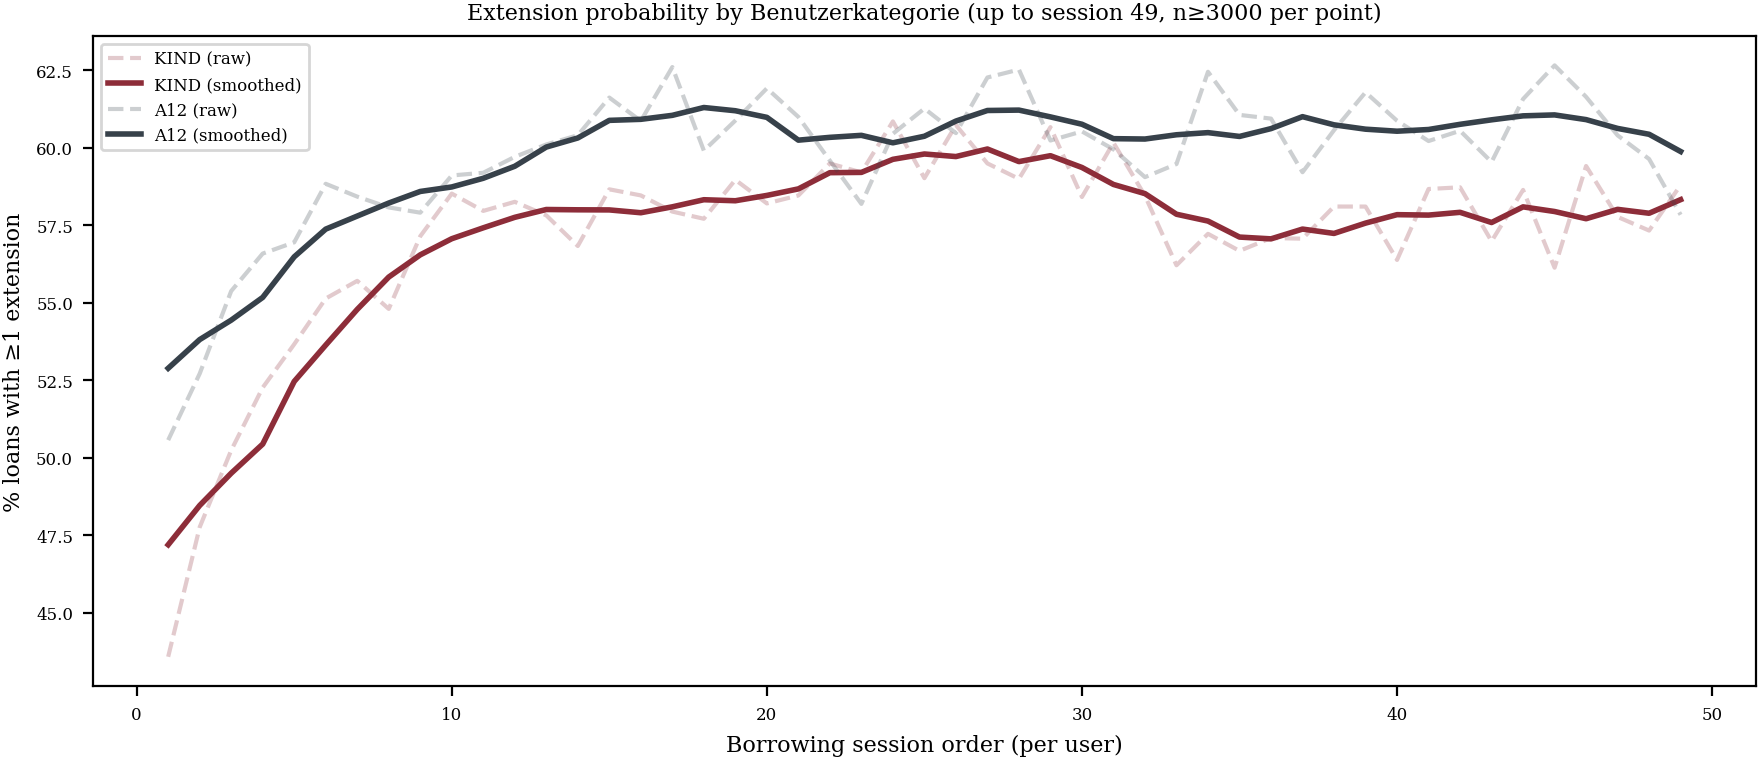

In [177]:
plot_extension_probability_curves_with_categories(df_learning, USER_CATEGORY_COL, ["KIND", "A12"])

Adults seem to extend more often in comparison to kids. The curves look pretty similar

## Do extensions differ in Media Types

Dropping categories that don't reach min_observations=200: ['Zeitschriften']


/tmp/ipykernel_67653/2576381268.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


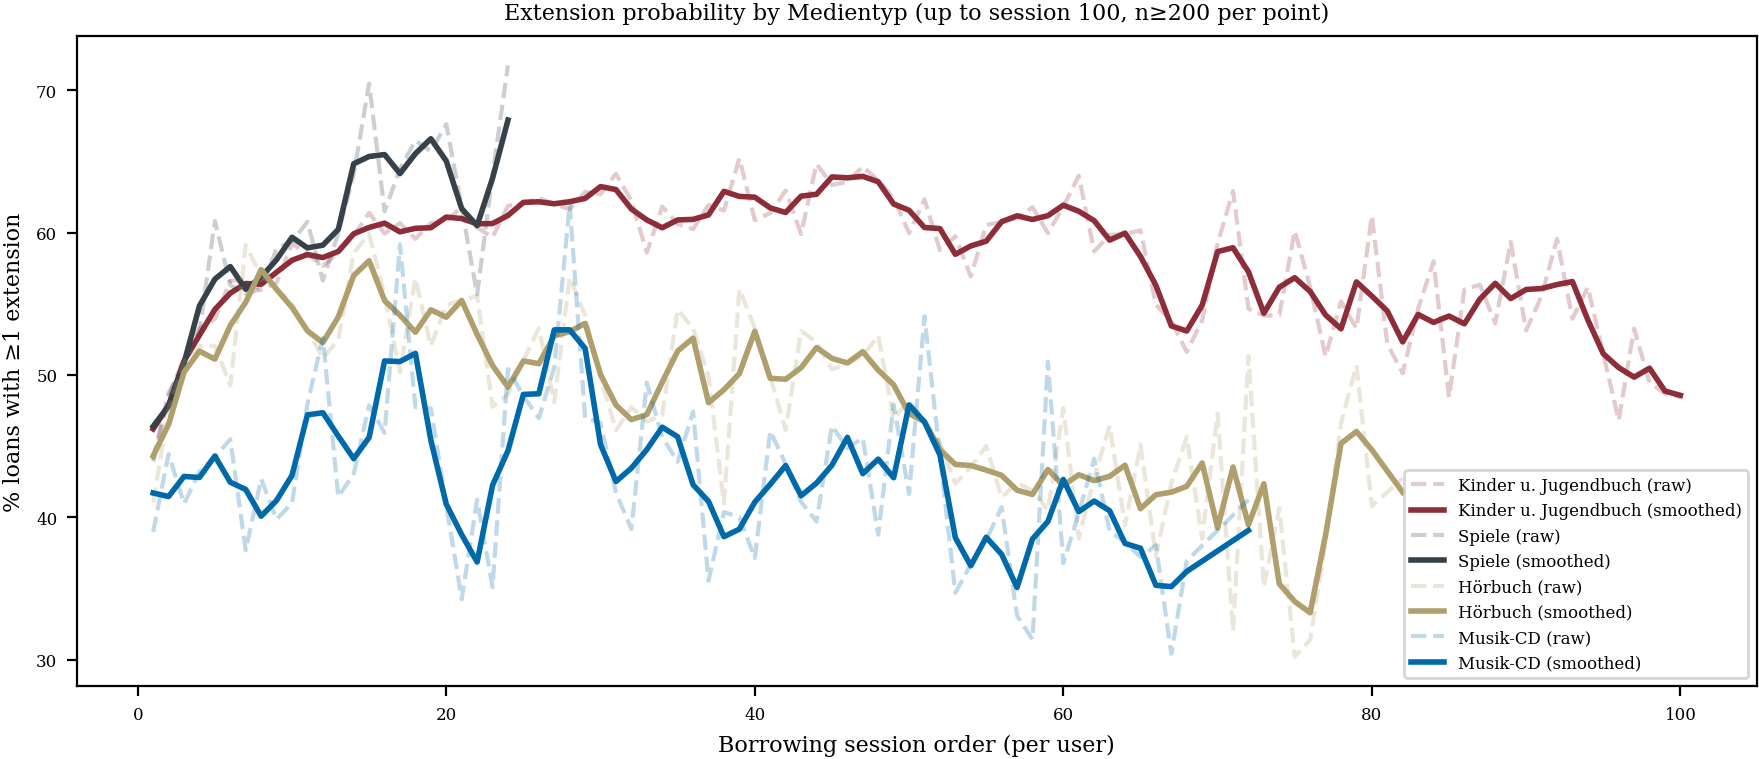

In [185]:
interesting_types = ["Kinder u. Jugendbuch", "Spiele", "Hörbuch", "Musik-CD",  "Zeitschriften"]

plot_extension_probability_curves_with_categories(
    df_learning,
    target_column="Medientyp",
    category_filter=interesting_types,
    min_observations=200,
    smooth_window=3,
    cutoff=100,
)


The curve is visible in almost all categories. One possible outlier is “Musik-CD,” which does not appear to show the characteristic early-session pattern.

## Do more experienced users loan more items at once?
One reason for the increase of extensions could be that user tend to loan more at once after a few sessions. We look at this behavior in the following plot.

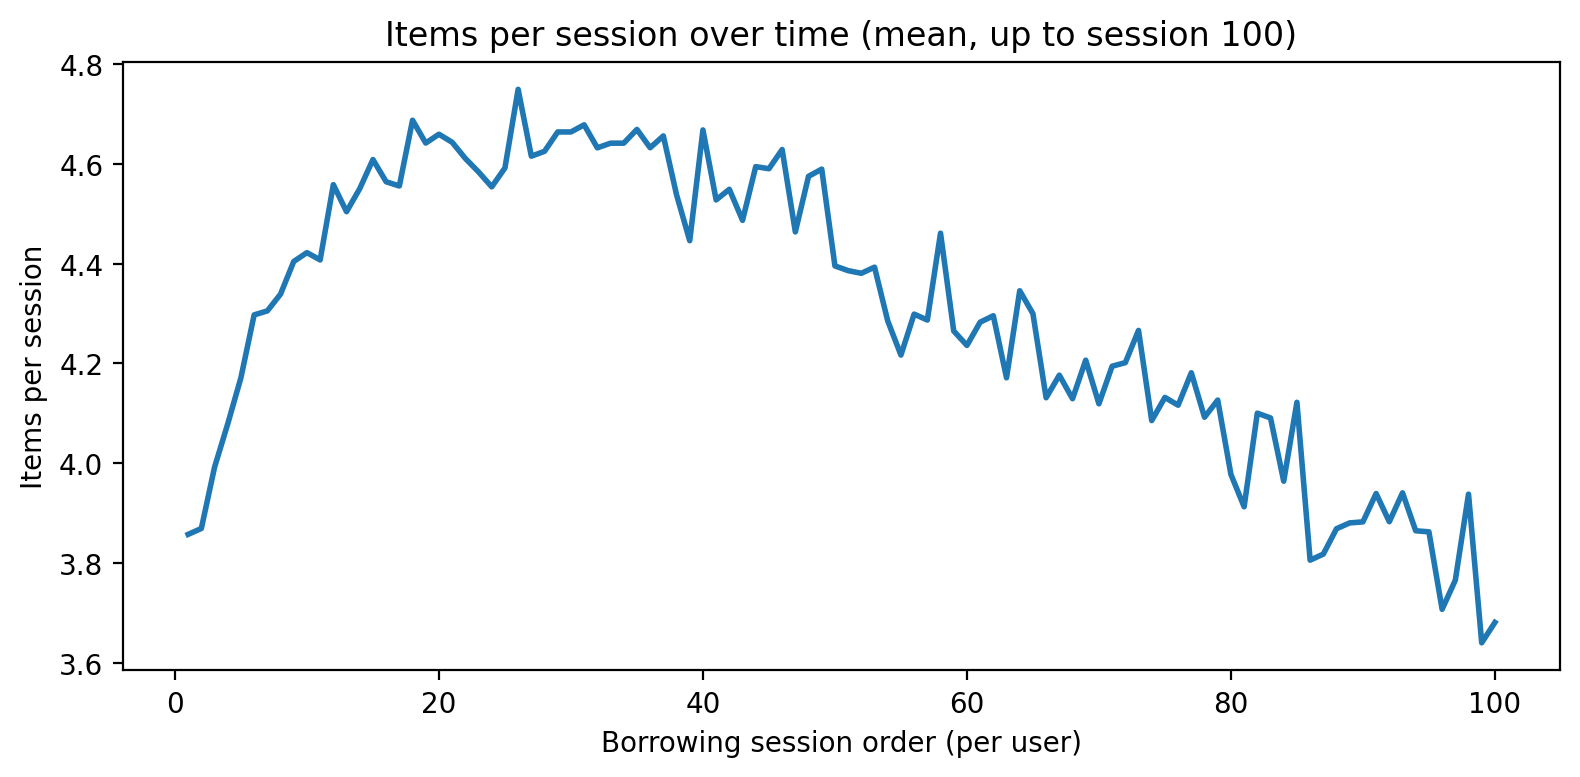

In [193]:
session = (
    df_learning
    .groupby([USER_ID_COL, "issue_session"])
    .size()
    .rename("n_items_in_session")
    .reset_index()
)
session = session.merge(
    df_learning[[USER_ID_COL, "issue_session", "session_index"]].drop_duplicates(),
    on=[USER_ID_COL, "issue_session"],
    how="left"
)

curve = (
    session.groupby("session_index")["n_items_in_session"]
    .agg(mean="mean", median="median", n_obs="count")
    .reset_index()
)

curve = curve[curve["session_index"] <= 100].copy()

plt.figure(figsize=(8,4))
plt.plot(curve["session_index"], curve["mean"], linewidth=2, label="Mean")
plt.xlabel("Borrowing session order (per user)")
plt.ylabel("Items per session")
plt.title("Items per session over time (mean, up to session 100)")
plt.tight_layout()
plt.show()




The increase at the beginning could be an explanation for the increase in extensions